In [1]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

batch_size = 128

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


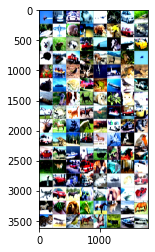

plane  car  car  catplane frog  car bird shipplane bird  cat  dog frogtruck frog  dog frog  cat  cartruckhorseplane  car  cat shiptruck deer  dog deer birdplane bird ship bird deerplaneplane frog frog  cat ship frog  car frog ship birdtruck ship bird  dog  dog  dog bird  cat shiphorse frog  cathorseplane ship  car  car deerhorsehorsehorsehorsetruck  car  cattruck bird deer  carhorseplanehorse bird  carhorse shiptruck bird froghorse  car deer  cat  cartruckhorsetruck deer ship bird  cartrucktruck  dogplane  cattruckplane  carhorse  doghorse  dog ship  carhorse frog  dog froghorse  dogplanehorse  catplane birdhorse deer deer ship  car


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
images[0].shape

torch.Size([3, 224, 224])

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride, downSample = False) -> None:
        super(BasicBlock, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(3, 3), stride=stride, padding=(1, 1)),
            nn.BatchNorm2d(num_features=planes),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(num_features=planes),
        )
        self.ReLU = nn.ReLU(inplace=True)
        self.downSample = self.downSampling(inplanes, planes) if downSample else None

    def forward(self, x):
        identity = x
        out = self.features(x)
        if self.downSample is not None:
            identity = self.downSample(x)
        out += identity
        out = self.ReLU(out)
        return out

    def downSampling(self, inplanes, planes):
        return nn.Sequential(
            nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=(1, 1), stride=(2, 2)),
            nn.BatchNorm2d(num_features=planes),
        )

class ResNet(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(ResNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),

            BasicBlock(64, 64, 1),
            BasicBlock(64, 64, 1),

            BasicBlock(64, 128, 2, True),
            BasicBlock(128, 128, 1),

            BasicBlock(128, 256, 2, True),
            BasicBlock(256, 256, 1),

            BasicBlock(256, 512, 2, True),
            BasicBlock(512, 512, 1),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
resnet = ResNet(len(classes))
resnet.to(device)

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (4): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (ReLU): ReLU(inplace=True)
    )
    (5): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [10]:
minimum_updates = 1000
minibatches_proccesed = 0
best_model_loss = 1e20
best_model_minibatch_time = 1e20
isStop = False
eval_interval = 50
PATH = './resnet.pth'

epoch = 0

train_loss_data = list()
train_accuracy_data = list()

test_loss_data = list()
test_accuracy_data = list()
while not isStop:

    running_loss = 0.0
    running_accuracy = 0.0

    test_running_loss = 0.0
    test_running_accuracy = 0.0

    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte/59013131
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        resnet.zero_grad()

        # 통계를 출력합니다.
        preds = torch.argmax(outputs.data, dim=1)

        running_loss += loss.item()
        running_accuracy += (labels == preds).float().mean()

        # minibatches_proccesed += 1

        # if minibatches_proccesed % eval_interval == (eval_interval - 1):
        #     if running_loss < best_model_loss and (running_accuracy / eval_interval) >= 0.8:
        #         best_model_loss = running_loss
        #         best_model_minibatch_time = minibatches_proccesed
        #         torch.save(resnet.state_dict(), PATH)
        #         print("Save model")

            # if minibatches_proccesed > minimum_updates and minibatches_proccesed >= best_model_minibatch_time + minimum_updates:
            #     isStop = True

    test_total = 0
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            outputs = resnet(images)
            loss = criterion(outputs, labels)

            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_running_loss += loss.item()
            test_running_accuracy += (predicted == labels).sum().item()

    train_loss_data.append(running_loss / len(trainloader))
    train_accuracy_data.append(running_accuracy / len(trainloader))

    test_loss_data.append(test_running_loss / len(testloader))
    test_accuracy_data.append(test_running_accuracy / test_total)
    
    print('[%d]\tTrain-\tloss: %.3f, accuracy: %.3f' % (epoch + 1, running_loss / len(trainloader), running_accuracy / len(trainloader)))
    print('    \tTest-\tloss: %.3f, accuracy: %.3f' % (test_running_loss / len(testloader), test_running_accuracy / test_total))

    if epoch == 9:
        isStop = True

    epoch += 1

print('Finished Training')

ValueError: only one element tensors can be converted to Python scalars

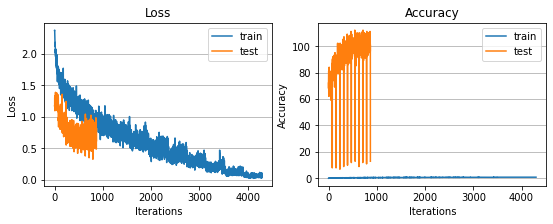

In [ ]:
# PATH = './resnet.pth'
# torch.save(resnet.state_dict(), PATH)
plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.title('Loss')
plt.plot(train_loss_data, label='train')
plt.plot(test_loss_data, label='test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True, axis='y')
plt.legend()

plt.subplot(122)
plt.title('Accuracy')
plt.plot(list(map(float, train_accuracy_data)), label='train')
plt.plot(list(map(float, test_accuracy_data)), label='test')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.grid(True, axis='y')
plt.legend()

plt.show()

# Prediction

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [ ]:
PATH = './resnet.pth'
resnet = ResNet(len(classes))
resnet.load_state_dict(torch.load(PATH))
resnet.to(device)

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (4): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (ReLU): ReLU(inplace=True)
    )
    (5): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
outputs = resnet(images.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


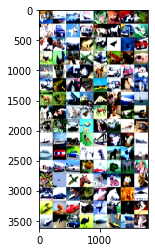

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat
Predicted:    cat   car  ship plane  frog horse   car  bird   cat plane plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck  deer  bird  deer plane truck  frog  frog   dog  deer   dog tr

In [ ]:
_, predicted = torch.max(outputs, 1)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [ ]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = resnet(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 79 %


In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        outputs = resnet(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 83.7 %
Accuracy for class car   is: 90.2 %
Accuracy for class bird  is: 70.1 %
Accuracy for class cat   is: 58.0 %
Accuracy for class deer  is: 75.8 %
Accuracy for class dog   is: 75.1 %
Accuracy for class frog  is: 86.4 %
Accuracy for class horse is: 81.3 %
Accuracy for class ship  is: 89.2 %
Accuracy for class truck is: 88.6 %
